**This file maps sum of trips on taxi zones**

**Author:** Eshan 

In [1]:
# Installing the required libraries
# Did not use cupy because macOS is not supported 

import os
import pandas as pd
import geopandas as gpd
import time 
import rasterio
from rasterio.features import rasterize
from rasterio.transform import from_bounds
import rioxarray as rxr
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from joblib import Parallel, delayed
import mapclassify

In [2]:
# Loading the shape file for tax zones
# The shape file is in data/nyc_taxi_zones_geo
current_dir = os.getcwd()
shapefile_path = os.path.join(current_dir, '..', 'data', 'nyc_taxi_zones_geo', 'geo_export_5d80cfbe-13fc-4d7a-a530-e88bb7a8d4ee.shp')
taxi_zones = gpd.read_file(shapefile_path)
taxi_zones = taxi_zones.to_crs(epsg=4326)

# Convert column location_i to string for merging
taxi_zones['location_i'] = taxi_zones['location_i'].astype(str)

taxi_zones.head()

,borough,location_i,objectid,shape_area,shape_leng,zone,geometry
0,EWR,1.0,1.0,0.000782,0.116357,Newark Airport,"POLYGON ((-74.18445 40.69500, -74.18449 40.695..."
1,Queens,2.0,2.0,0.004866,0.433470,Jamaica Bay,"MULTIPOLYGON (((-73.82338 40.63899, -73.82277 ..."
2,Bronx,3.0,3.0,0.000314,0.084341,Allerton/Pelham Gardens,"POLYGON ((-73.84793 40.87134, -73.84725 40.870..."
3,Manhattan,4.0,4.0,0.000112,0.043567,Alphabet City,"POLYGON ((-73.97177 40.72582, -73.97179 40.725..."
4,Staten Island,5.0,5.0,0.000498,0.092146,Arden Heights,"POLYGON ((-74.17422 40.56257, -74.17349 40.562..."


In [28]:
# Importing the taxitrips data (provided by Jen)
taxitrips_path = os.path.join(current_dir, '..', 'data', 'taxi_trips','taxi_data_withFlagForPeakHours.csv')
taxitrips = pd.read_csv(taxitrips_path)

# Format DOLocationID to have one decimal place
taxitrips['DOLocationID'] = taxitrips['DOLocationID'].apply(lambda x: f"{float(x):.1f}")

taxitrips.head()

,DOLocationID,dropoff_count,flag_dropoff_peak_hours
0,1.0,33316,0
1,1.0,142198,1
2,10.0,10740,0
3,10.0,53862,1
4,100.0,167250,0


In [29]:
# Merging taxitrips with taxi_zones
taxitrips_merged = taxitrips.merge(taxi_zones, left_on='DOLocationID', right_on='location_i', how='left')

# Check if the merged DataFrame is a GeoDataFrame
is_geodataframe = isinstance(taxitrips_merged, gpd.GeoDataFrame)
print(f"Is the merged DataFrame a GeoDataFrame? {is_geodataframe}")

# If it's not, convert it to a GeoDataFrame using the geometry column
if not is_geodataframe:
    taxitrips_merged = gpd.GeoDataFrame(taxitrips_merged, geometry='geometry')
    
# Examine the merged data
taxitrips_merged.head()

Is the merged DataFrame a GeoDataFrame? False


,DOLocationID,dropoff_count,flag_dropoff_peak_hours,borough,location_i,objectid,shape_area,shape_leng,zone,geometry
0,1.0,33316,0,EWR,1.0,1.0,0.000782,0.116357,Newark Airport,"POLYGON ((-74.18445 40.69500, -74.18449 40.695..."
1,1.0,142198,1,EWR,1.0,1.0,0.000782,0.116357,Newark Airport,"POLYGON ((-74.18445 40.69500, -74.18449 40.695..."
2,10.0,10740,0,Queens,10.0,10.0,0.000436,0.099839,Baisley Park,"POLYGON ((-73.78327 40.68999, -73.78234 40.688..."
3,10.0,53862,1,Queens,10.0,10.0,0.000436,0.099839,Baisley Park,"POLYGON ((-73.78327 40.68999, -73.78234 40.688..."
4,100.0,167250,0,Manhattan,100.0,100.0,0.000037,0.024813,Garment District,"POLYGON ((-73.98729 40.75045, -73.98777 40.749..."


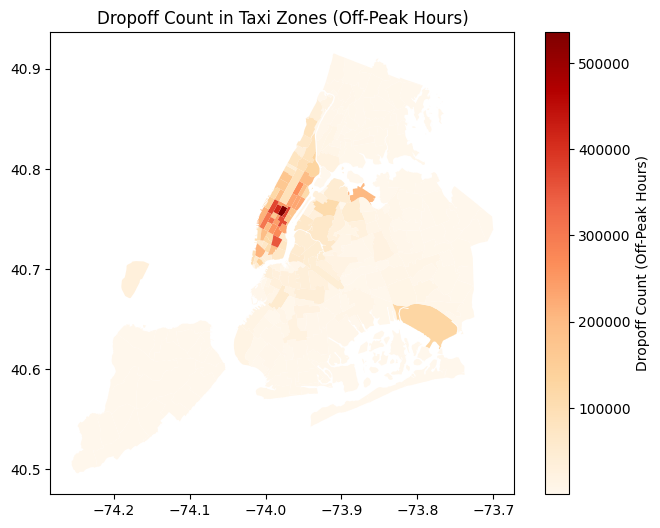

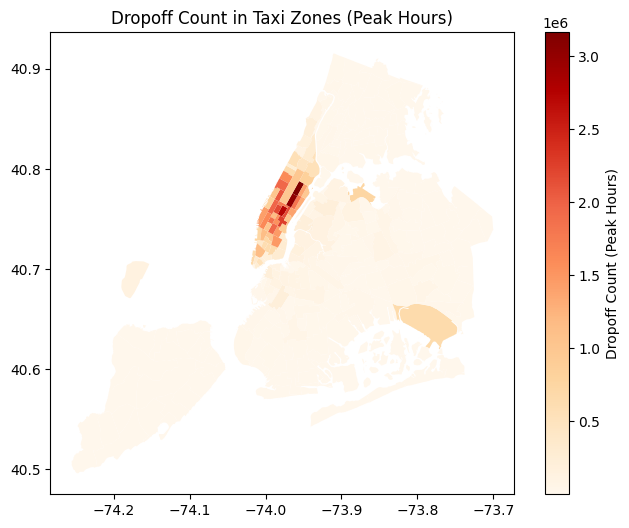

In [30]:
# Separate data based on flag_dropoff_peak_hours
taxitrips_merged_peak = taxitrips_merged[taxitrips_merged['flag_dropoff_peak_hours'] == 1]
taxitrips_merged_offpeak = taxitrips_merged[taxitrips_merged['flag_dropoff_peak_hours'] == 0]

# Plot dropoff_count for taxi zones with flag_dropoff_peak_hours = 0
fig, ax = plt.subplots(1, 1, figsize=(8,6))
taxitrips_merged_offpeak.plot(column='dropoff_count', ax=ax, legend=True, 
                       legend_kwds={'label': "Dropoff Count (Off-Peak Hours)", 'orientation': "vertical"},
                       cmap='OrRd')
ax.set_title('Dropoff Count in Taxi Zones (Off-Peak Hours)')
plt.show()

# Plot dropoff_count for taxi zones with flag_dropoff_peak_hours = 1
fig, ax = plt.subplots(1, 1, figsize=(8,6))
taxitrips_merged_peak.plot(column='dropoff_count', ax=ax, legend=True, 
                    legend_kwds={'label': "Dropoff Count (Peak Hours)", 'orientation': "vertical"},
                    cmap='OrRd')
ax.set_title('Dropoff Count in Taxi Zones (Peak Hours)')
plt.show()

In [31]:
# Import droff by hour and taxi zone
dropoff_by_hour_path = os.path.join(current_dir, '..', 'data', 'taxi_trips', 'nyc_taxi_rides_2019_aggByDOandHour.csv')
dropoff_by_hour = pd.read_csv(dropoff_by_hour_path)

# Format DOLocationID to have one decimal place
dropoff_by_hour['DOLocationID'] = dropoff_by_hour['DOLocationID'].apply(lambda x: f"{float(x):.1f}")

dropoff_by_hour.head()

,hour_of_day,DOLocationID,dropoff_count
0,0,1.0,262
1,0,10.0,2948
2,0,100.0,30752
3,0,101.0,251
4,0,102.0,798


In [32]:
# Merging dropoffs with taxi_zones
dropoffs_merged = dropoff_by_hour.merge(taxi_zones, left_on='DOLocationID', right_on='location_i', how='left')

# Check if the merged DataFrame is a GeoDataFrame
is_geodataframe = isinstance(dropoffs_merged, gpd.GeoDataFrame)
print(f"Is the merged DataFrame a GeoDataFrame? {is_geodataframe}")

# If it's not, convert it to a GeoDataFrame using the geometry column
if not is_geodataframe:
    dropoffs_merged = gpd.GeoDataFrame(dropoffs_merged, geometry='geometry')
    
# Examine the merged data
dropoffs_merged.head()

Is the merged DataFrame a GeoDataFrame? False


,hour_of_day,DOLocationID,dropoff_count,borough,location_i,objectid,shape_area,shape_leng,zone,geometry
0,0,1.0,262,EWR,1.0,1.0,0.000782,0.116357,Newark Airport,"POLYGON ((-74.18445 40.69500, -74.18449 40.695..."
1,0,10.0,2948,Queens,10.0,10.0,0.000436,0.099839,Baisley Park,"POLYGON ((-73.78327 40.68999, -73.78234 40.688..."
2,0,100.0,30752,Manhattan,100.0,100.0,0.000037,0.024813,Garment District,"POLYGON ((-73.98729 40.75045, -73.98777 40.749..."
3,0,101.0,251,Queens,101.0,101.0,0.000452,0.101710,Glen Oaks,"POLYGON ((-73.70135 40.75078, -73.70117 40.748..."
4,0,102.0,798,Queens,102.0,102.0,0.000297,0.136900,Glendale,"POLYGON ((-73.85596 40.70643, -73.85594 40.706..."


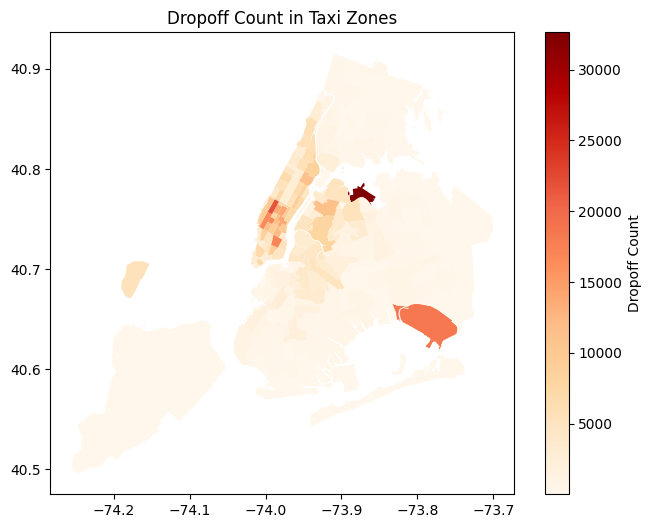

In [33]:
# Separate data based on flag_dropoff_peak_hours
dropoffs_merged_hour = dropoffs_merged[dropoffs_merged['hour_of_day'] == 4]

# Plot dropoff_count for taxi zones with flag_dropoff_peak_hours = 0
fig, ax = plt.subplots(1, 1, figsize=(8,6))
dropoffs_merged_hour.plot(column='dropoff_count', ax=ax, legend=True, 
                       legend_kwds={'label': "Dropoff Count", 'orientation': "vertical"},
                       cmap='OrRd')
ax.set_title('Dropoff Count in Taxi Zones')
plt.show()

In [34]:
# Importing taxi pickup data for exploration
pickup_by_hour_path = os.path.join(current_dir, '..', 'data', 'taxi_trips', 'nyc_taxi_rides_2019_aggByPUandHour.csv')
pickup_by_hour = pd.read_csv(pickup_by_hour_path)

# Format DOLocationID to have one decimal place
pickup_by_hour['PULocationID'] = pickup_by_hour['PULocationID'].apply(lambda x: f"{float(x):.1f}")

pickup_by_hour.head()

,hour_of_day,PULocationID,pickup_count
0,0,1.0,28
1,0,10.0,621
2,0,100.0,49034
3,0,101.0,26
4,0,102.0,30


In [35]:
# Merging pickups with taxi_zones
pickups_merged = pickup_by_hour.merge(taxi_zones, left_on='PULocationID', right_on='location_i', how='left')

# Check if the merged DataFrame is a GeoDataFrame
is_geodataframe = isinstance(pickups_merged, gpd.GeoDataFrame)
print(f"Is the merged DataFrame a GeoDataFrame? {is_geodataframe}")

# If it's not, convert it to a GeoDataFrame using the geometry column
if not is_geodataframe:
    pickups_merged = gpd.GeoDataFrame(pickups_merged, geometry='geometry')
    
# Examine the merged data
pickups_merged.head()

Is the merged DataFrame a GeoDataFrame? False


,hour_of_day,PULocationID,pickup_count,borough,location_i,objectid,shape_area,shape_leng,zone,geometry
0,0,1.0,28,EWR,1.0,1.0,0.000782,0.116357,Newark Airport,"POLYGON ((-74.18445 40.69500, -74.18449 40.695..."
1,0,10.0,621,Queens,10.0,10.0,0.000436,0.099839,Baisley Park,"POLYGON ((-73.78327 40.68999, -73.78234 40.688..."
2,0,100.0,49034,Manhattan,100.0,100.0,0.000037,0.024813,Garment District,"POLYGON ((-73.98729 40.75045, -73.98777 40.749..."
3,0,101.0,26,Queens,101.0,101.0,0.000452,0.101710,Glen Oaks,"POLYGON ((-73.70135 40.75078, -73.70117 40.748..."
4,0,102.0,30,Queens,102.0,102.0,0.000297,0.136900,Glendale,"POLYGON ((-73.85596 40.70643, -73.85594 40.706..."


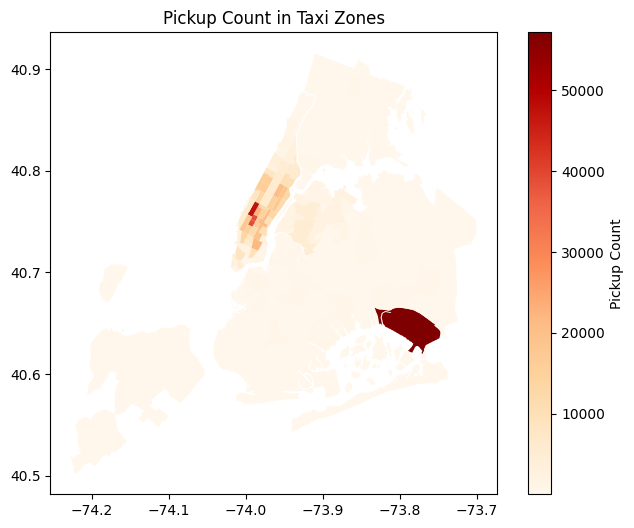

In [43]:
# Separate data based on flag_dropoff_peak_hours
pickups_merged_hour = pickups_merged[pickups_merged['hour_of_day'] == 5]

# Plot pickup counts for taxi zones pickup hour as defined above = 0
fig, ax = plt.subplots(1, 1, figsize=(8,6))
pickups_merged_hour.plot(column='pickup_count', ax=ax, legend=True, 
                       legend_kwds={'label': "Pickup Count", 'orientation': "vertical"},
                       cmap='OrRd')
ax.set_title('Pickup Count in Taxi Zones')
plt.show()